In [36]:
from keras.layers import *
from keras.losses import mse
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Setup Google CoLab Environment

In [9]:
# Import data on Google CoLab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/2.\ Autoencoder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/2. Autoencoder


# Importing relevant functions and libraries

In [0]:
%run "Reusable_Functions.ipynb"

# Import Data

In [12]:
# Import data offline
cplr, mech = import_DB()
print(cplr.shape)
print(mech.shape)

(1902, 100, 3)
(1902, 11, 3)


In [0]:
# Renormalize DB from range [-1,1] to range [0,1] 
n_cplr=cplr/2+.5
n_mech=mech/2+.5

# Splitting the database in Train/Test dataset

In [14]:
x= n_cplr

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, _, _ = train_test_split(x, x, test_size=0.2, random_state=1)

print(x_train.shape)
print(x_test.shape)

(1521, 100, 3)
(381, 100, 3)


# Variational Autoencoder Z=30

In [40]:
def sampling(args):
    mu, log_var = args
    batch_size = K.shape(mu)[0]
    z_dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var/2.) * eps

def VAE_Z30():
    z_dim=30
    inp=Input(shape=(100,3))

    # Encoding
    x=Flatten()(inp)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    x=Dense(150, activation='relu')(z)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    y=Reshape((100, 3))(x)
    
    # loss
    reconstruction_loss = mse(inp, y)
    kl_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis = -1)
    vae_loss = reconstruction_loss + kl_loss

    # build model
    vae = Model(inputs=[inp], outputs=[y])
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    
    encoder = Model(inputs=[inp], outputs=[z_mean])
    return vae, encoder

#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
#AE,E,train_data =AE_analysis(VAE_Z30, 10, x_train, x_test, filename='VAE_Z30')
vae,_=VAE_Z30()
train_data=vae.fit(x_train, x_train, shuffle=True, epochs=500, batch_size=128, validation_data=(x_test, x_test), verbose=0)
visualize_AE(vae, train_data, x_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 100, 3)       0                                            
__________________________________________________________________________________________________
flatten_23 (Flatten)            (None, 300)          0           input_19[0][0]                   
__________________________________________________________________________________________________
dense_160 (Dense)               (None, 150)          45150       flatten_23[0][0]                 
__________________________________________________________________________________________________
dense_161 (Dense)               (None, 150)          22650       dense_160[0][0]                  
__________________________________________________________________________________________________
dense_162 

NameError: name 'x_train' is not defined

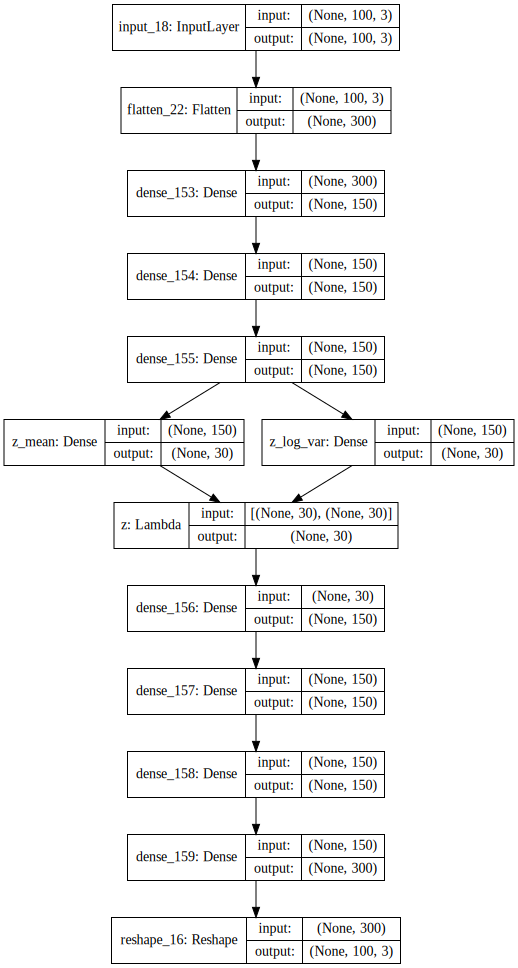

In [39]:
SVG(model_to_dot(vae, show_shapes='true', show_layer_names='true').create(prog='dot', format='svg'))

In [ ]:
# Disentangling VAE

In [1]:
# Deep feature consistent variational auto-encoder
# using 'feature perceptual loss' instead of 'reconstruction loss'
# needs a pre-trained 'perception model'

In [ ]:
# Conditional VAE
# for path completion
# Train using mask and respective incomplete paths as input and full path as output.
def CVAE_Z30():
    z_dim=30
    inp=Input(shape=(100,3))
    condition=Input(shape=(100,1))
    inp_cond= concatenate([x, condition])

    # Encoding
    x=Flatten()(inp_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    z_cond = concatenate([z, condition])
    x=Dense(150, activation='relu')(z_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    y=Reshape((100, 3))(x)
    
    # loss
    reconstruction_loss = mse(inp, y)
    kl_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis = -1)
    vae_loss = reconstruction_loss + kl_loss

    # build model
    cvae = Model(inputs=[inp,condition], outputs=[y])
    cvae.add_loss(vae_loss)
    cvae.compile(optimizer='adam')
    cvae.summary()
    
    encoder = Model(inputs=[inp,condition], outputs=[z_mean])
    return cvae, encoder

cvae,_=CVAE_Z30()
train_data=cvae.fit([x_train, cond_train], x_train, shuffle=True, epochs=500, batch_size=128, 
                    validation_data=([x_test, cond_train], x_test), verbose=0)
visualize_AE(cvae, train_data, x_test)

In [ ]:
# Shared Encoder CVAE
# Has single encoder and multiple decoders
# Used to generate DeepFake/FaceSwap

def BCVAE_encoder():
    z_dim=30
    inp=Input(shape=(100,3))
    condition=Input(shape=(100,1))
    inp_cond= concatenate([x, condition])

    # Encoding
    x=Flatten()(inp_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])
    
    return encoder = Model(inputs=[inp,condition], outputs=[z])
    
def SCVAE_decoder():
    z_dim=30
    inp=Input(shape=(100,3))
    condition=Input(shape=(100,1))
    inp_cond= concatenate([x, condition])

    # Encoding
    x=Flatten()(inp_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])
    
    return encoder = Model(inputs=[inp,condition], outputs=[z])
    

In [ ]:
# use domain knowledge and use multiple parallel input lambda layers for FDs, CAD, wavelets, etc